# Use Toronto neihgbourhood data to generate meaningful location data for bikeshare locations

In [1]:
import pandas as pd
import geopandas as gpd
#import geoplot as gplt
#import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import requests
import json
from shapely.geometry import shape

# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "neighbourhoods"}
package = requests.get(url, params = params).json()
#print(package["result"])

"""url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"}
package = requests.get(url, params = params).json()"""


# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:

for idx, resource in enumerate(package["result"]["resources"]):
    #print(resource)
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"], "limit": 32000 }
        data = requests.get(url, params = p).json()
        df = pd.DataFrame(data["result"]["records"])
        break
        
#define function to parse the geometry column
#This is not extremely efficient but I can't figure out how another work around 
#besides downloading the JSON file and useing gpd.read_file
def parse_geom(geom_str):
    return shape(json.loads(geom_str))
    try:
        return shape(json.loads(geom_str))
    except (TypeError, AttributeError):  # Handle NaN and empty strings
        return None
#assign the function to the correct column
df["geometry"] = df["geometry"].apply(parse_geom)

#turn this into a geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry="geometry")

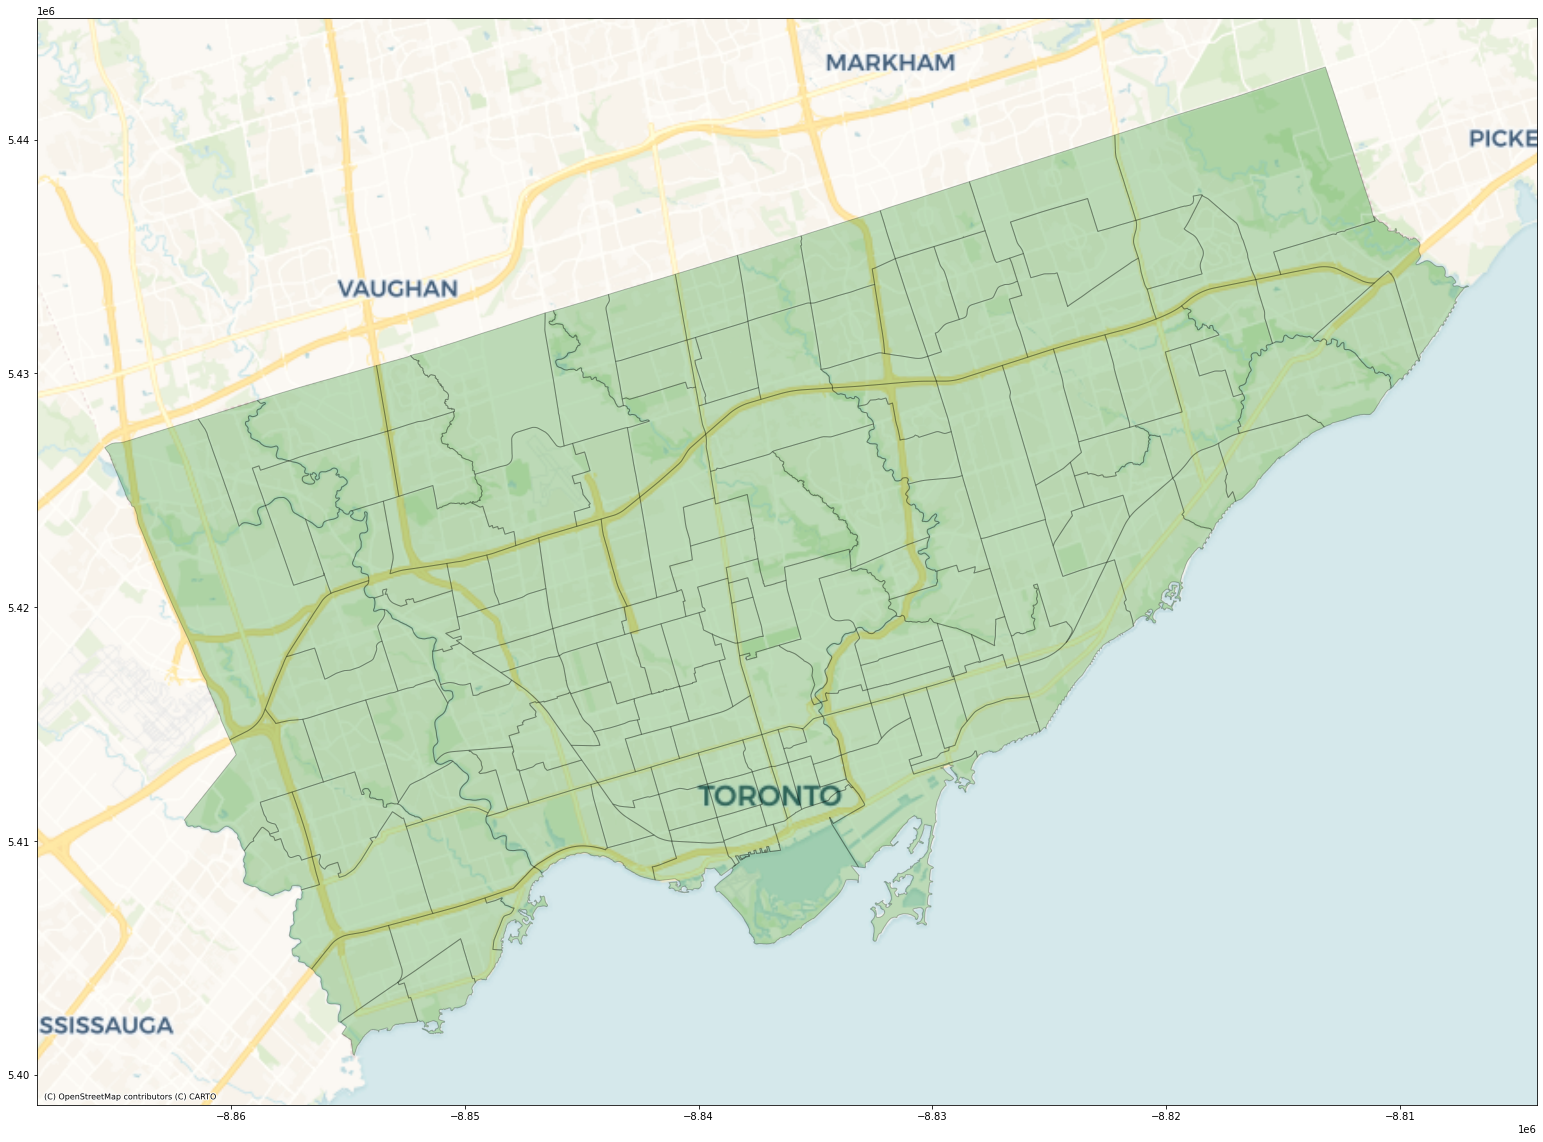

In [2]:
import contextily as cx#for adding base map

#turn this into a geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry="geometry")
#set coordinates system
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs(epsg=3857)# alternatively you can use the crs paramter in add_basemap to change that id hte dataset is too large
ax = gdf.plot(figsize=(40,20), color = 'g', alpha = 0.25, edgecolor = 'k')
cx.add_basemap(ax,zoom = 11, source=cx.providers.CartoDB.Voyager)


In [3]:
stations = pd.read_json('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information', lines=True)
stations.head()
print(stations['data'][0]['stations'][0].keys())

dict_keys(['station_id', 'name', 'physical_configuration', 'lat', 'lon', 'altitude', 'address', 'capacity', 'is_charging_station', 'rental_methods', 'groups', 'obcn', 'nearby_distance', '_ride_code_support'])


In [5]:
s = stations['data'][0]['stations']
s = pd.DataFrame(s)
s.head()


,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,is_charging_station,rental_methods,groups,obcn,nearby_distance,_ride_code_support,post_code,cross_street
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9607,500.0,True,NaN,NaN
1,7001,Wellesley Station Green P (EBS),ELECTRICBIKESTATION,43.664964,-79.383550,0.0,Yonge / Wellesley,26,True,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],416-617-9576,500.0,True,M4Y 1G7,NaN
2,7002,St. George St / Bloor St W,REGULAR,43.667333,-79.399429,0.0,St. George St / Bloor St W,19,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9615,500.0,True,NaN,NaN
3,7003,Madison Ave / Bloor St W,REGULAR,43.667158,-79.402761,NaN,Madison Ave / Bloor St W,15,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-631-4587,500.0,True,NaN,NaN
4,7004,University Ave / Elm St,REGULAR,43.656518,-79.389099,NaN,University Ave / Elm St,11,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[P7004-7047],647-643-9673,500.0,True,NaN,NaN


In [12]:
#make coordinates into geometry geopandas
stations = gpd.GeoDataFrame(s, geometry=gpd.points_from_xy(s.lon, s.lat))
stations.head()
#stations.shape

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,is_charging_station,rental_methods,groups,obcn,nearby_distance,_ride_code_support,post_code,cross_street,geometry
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,0.0,Fort York Blvd / Capreol Ct,35,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9607,500.0,True,NaN,NaN,POINT (-79.39595 43.63983)
1,7001,Wellesley Station Green P (EBS),ELECTRICBIKESTATION,43.664964,-79.383550,0.0,Yonge / Wellesley,26,True,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],416-617-9576,500.0,True,M4Y 1G7,NaN,POINT (-79.38355 43.66496)
2,7002,St. George St / Bloor St W,REGULAR,43.667333,-79.399429,0.0,St. George St / Bloor St W,19,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-643-9615,500.0,True,NaN,NaN,POINT (-79.39943 43.66733)
3,7003,Madison Ave / Bloor St W,REGULAR,43.667158,-79.402761,NaN,Madison Ave / Bloor St W,15,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[],647-631-4587,500.0,True,NaN,NaN,POINT (-79.40276 43.66716)
4,7004,University Ave / Elm St,REGULAR,43.656518,-79.389099,NaN,University Ave / Elm St,11,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[P7004-7047],647-643-9673,500.0,True,NaN,NaN,POINT (-79.38910 43.65652)


In [7]:
stations = stations.set_crs("EPSG:4326")
stations = stations.to_crs(epsg=3857)

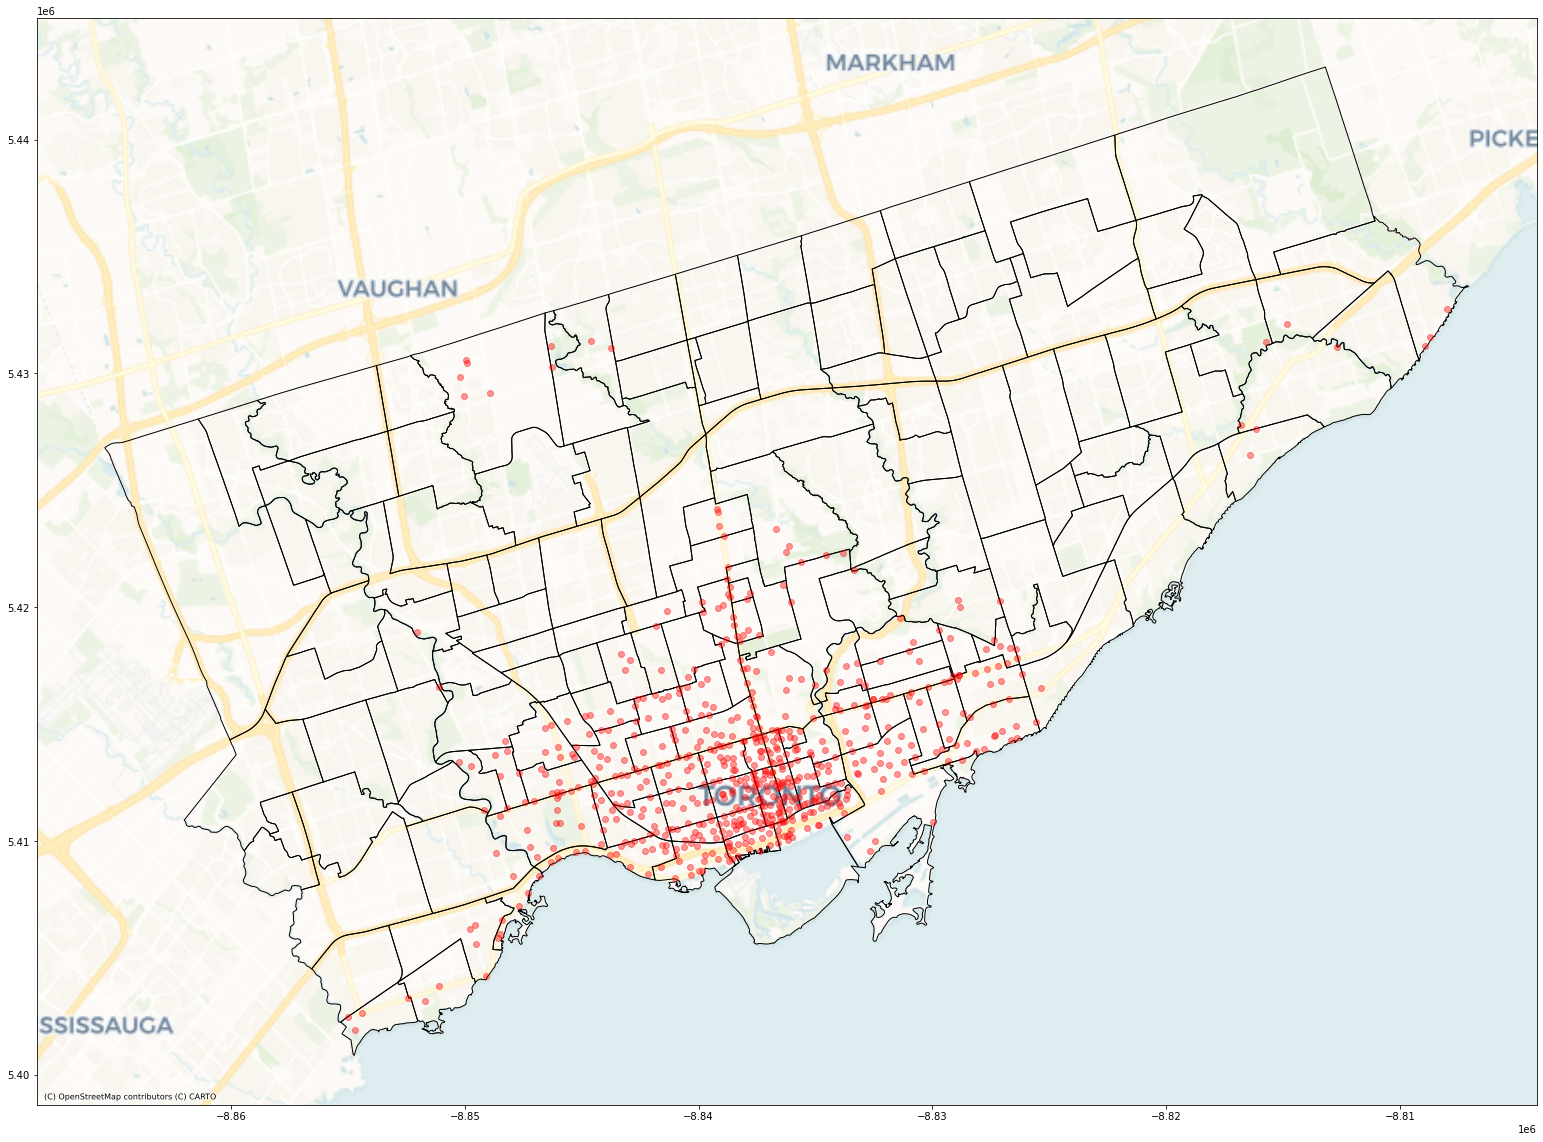

In [11]:
#turn this into a geopandas dataframe

ax = gdf.plot(figsize=(40,20), facecolor = 'none', edgecolor = 'k')
stations.plot(ax = ax, color='red', alpha = 0.4)
cx.add_basemap(ax,zoom = 11, alpha = 0.75, source=cx.providers.CartoDB.Voyager)

In [16]:
s.set_index('station_id',inplace=True)
d = s.to_dict('index')
d['7000']['lat']

43.639832